## Objective of Analysis
When a bank receives a loan application, based on the applicant’s profile the bank has to make a decision regarding whether to go ahead with the loan approval or not.

Two types of risks are associated with the bank’s decision:
- If the applicant is a good credit risk, i.e. is likely to repay the loan, then not approving the loan to the person results in a loss of business to the bank
- If the applicant is a bad credit risk, i.e. is not likely to repay the loan, then approving the loan to the person results in a financial loss to the bank

The objective of analysis id to develop a predictive model to provide a bank manager guidance for making a decision whether to approve a loan to a prospective applicant based on his/her profiles.

## Dataset
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. (https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)

Here we use a simplified dataset with selected columns of the original dataset. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

The selected attributes are:
- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
- Risk (Value target - Good or Bad Risk)


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                        
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Exploratory Data Analysis

#### Load Data

In [45]:
df = pd.read_csv('german_credit_data_with_target.csv', index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [46]:
# check null values
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

#### Categorical Variables

In [47]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']
cat_cols

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

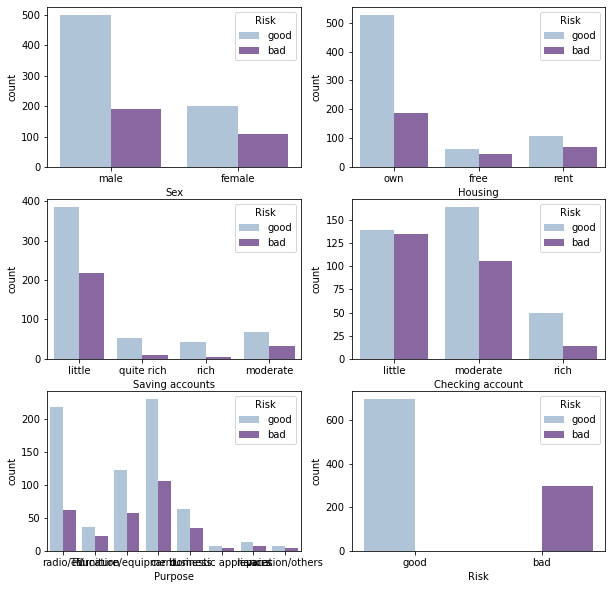

In [48]:
fig , ax = plt.subplots(3,2,figsize = (10,10))     # set up 3 x 2 frame count plot with figsize 10 x 10
for i , subplots in zip (cat_cols, ax.flatten()):  
    sns.countplot(x = i, data = df, ax = subplots, hue = df['Risk'], palette = 'BuPu')
plt.show()

#### Numerical Variables

In [49]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O']
num_cols

['Age', 'Job', 'Credit amount', 'Duration']

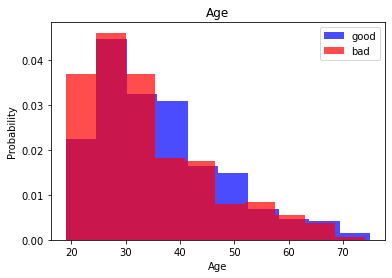

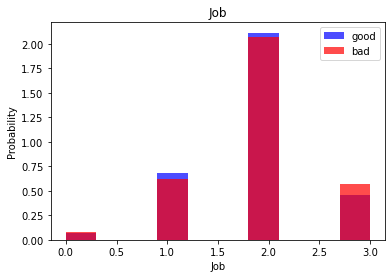

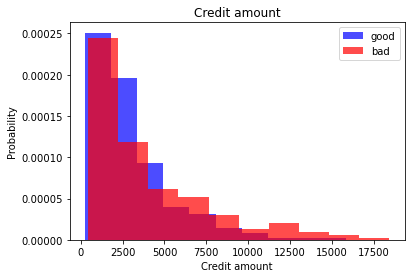

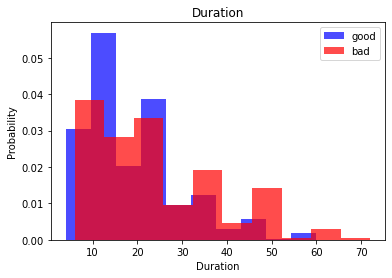

In [50]:
for col in num_cols:
    plt.hist(df[df["Risk"]=='good'][col], color='blue', label='good', alpha=0.7, density=True)
    plt.hist(df[df["Risk"]=='bad'][col], color='red', label='bad', alpha=0.7, density=True)
    plt.title(col)
    plt.ylabel("Probability")
    plt.xlabel(col)
    plt.legend()
    plt.show()

## Data Pre-processing & Feature Engineering

#### Missing Values

In [51]:
#Filling missing values with mode
df["Saving accounts"].fillna(df['Saving accounts'].mode()[0], inplace=True)
df["Checking account"].fillna(df['Checking account'].mode()[0], inplace=True)

#### One-hot Encoding for Categorical Variables

In [52]:
df["Risk"] = (df["Risk"] == "bad").astype(int) # bad=1, good=0
features = df.columns.to_list()
features.remove('Risk')
label = 'Risk'
cat_cols.remove('Risk')

In [53]:
def one_hot_encoder(dataframe, categorical_cols, nan_as_category=True):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols)
    new_columns = [c for c in dataframe.columns if c not in original_columns]
    return dataframe, new_columns

In [54]:
df_new, new_cols_ohe = one_hot_encoder(df, cat_cols)

In [55]:
df_new

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,22,2,5951,48,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,49,1,2096,12,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,45,2,7882,42,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,1,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,1736,12,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
996,40,3,3857,30,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
997,38,2,804,12,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
998,23,2,1845,45,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0


#### Correlation Analysis

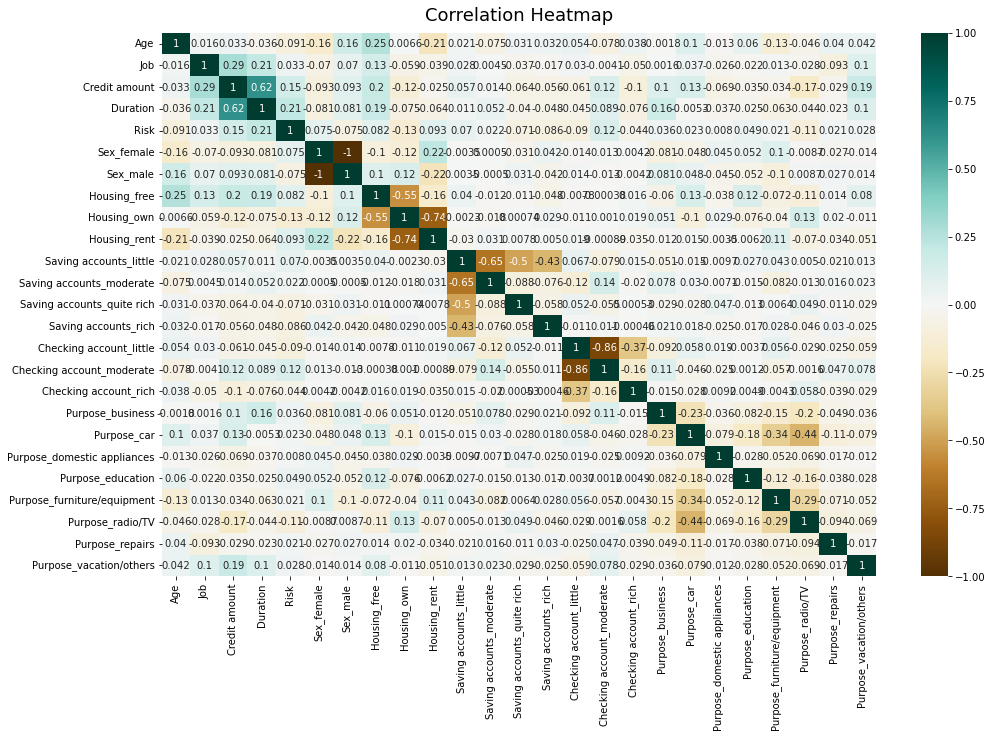

In [59]:
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df_new.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

## Modeling

#### Standardization

In [66]:
#Creating the X and y variables
X = df_new.drop('Risk', 1).values
y = df_new['Risk'].values

# standard scalar
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#### Baseline Models

In [71]:
# set the random state
seed = 7

# set the baseline models
models = []
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGBM', XGBClassifier()))

In [75]:
# model evaluation
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=5)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s %f" % (name+' mean recall:', cv_results.mean())
        print(msg)

LGR mean recall: 0.262290
LDA mean recall: 0.257121
CART mean recall: 0.423634
NB mean recall: 0.508613
RF mean recall: 0.279757
SVM mean recall: 0.114071
XGBM mean recall: 0.306143


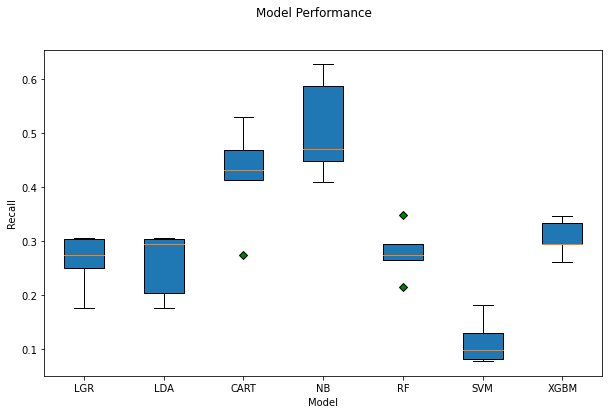

In [76]:
# comparison with boxplot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Model Performance')
ax = fig.add_subplot(111)
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(results, flierprops=green_diamond, patch_artist=True)
ax.set_xticklabels(names)
plt.ylabel("Recall")
plt.xlabel("Model")
plt.show()

It seems like Naive Base, Random Forest, and XGBoost have better performance. Next step is to do hyperparameter Optimization on these models to find the best model with the best parameters.

#### Naive Bayes

In [78]:
GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

# predixtion on testing data
y_pred = model.predict(X_test)

print("Classification Report on Testing Data: \n", classification_report(y_test, y_pred))

Classification Report on Testing Data: 
               precision    recall  f1-score   support

           0       0.73      0.71      0.72       141
           1       0.35      0.37      0.36        59

    accuracy                           0.61       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.62      0.61      0.61       200



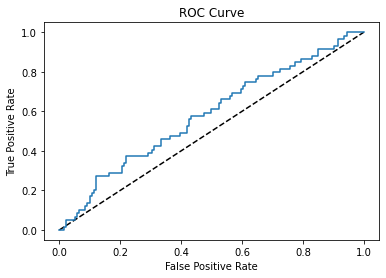

In [79]:
# Prediction proba
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Random Forest

In [120]:
classifier = RandomForestClassifier()

param_grid = {"n_estimators": [100, 200, 300, 500, 700, 1000], 
              "max_depth": [3, 5, 7, 11, 15],
              "criterion": ["gini", "entropy"]
             }

In [121]:
model = model_selection.GridSearchCV(
    estimator=classifier, # the model we difined
    param_grid=param_grid, # grid of parameters
    scoring="roc_auc", 
    cv=5 
)

In [122]:
model.fit(X_train, y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params() 
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Best score: 0.6839427916436845
Best parameters set:
	criterion: entropy
	max_depth: 5
	n_estimators: 1000


In [123]:
# get the best model
best_rf = model.best_estimator_

y_pred = best_rf.predict(X_test)
print("Classification Report on Testing Data: \n", classification_report(y_test, y_pred))

Classification Report on Testing Data: 
               precision    recall  f1-score   support

           0       0.72      0.99      0.84       141
           1       0.83      0.08      0.15        59

    accuracy                           0.73       200
   macro avg       0.78      0.54      0.49       200
weighted avg       0.75      0.72      0.63       200



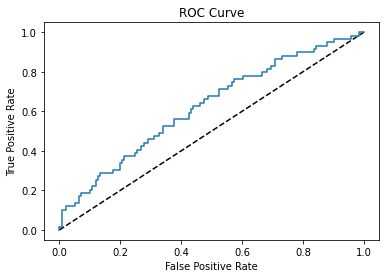

In [124]:
# Prediction proba
y_pred_prob = best_rf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

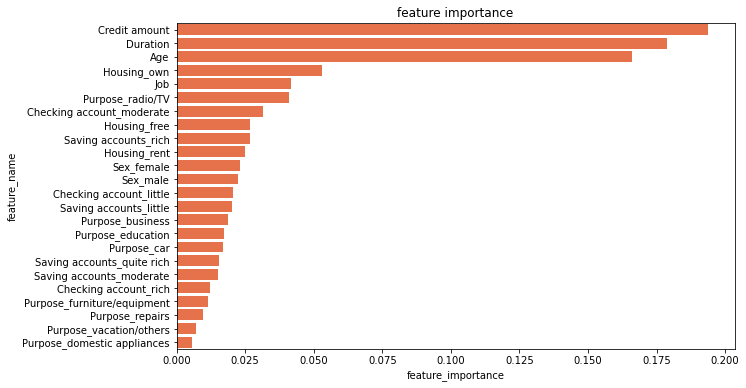

In [125]:
features = df_new.columns.to_list()
features.remove('Risk')

plt.figure(figsize=(10, 6))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance': best_rf.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()

#### XGBoost

In [114]:
classifier = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'gamma': [0.05, 0.1, 0.3],
    'learning_rate': [0.01, 0.025, 0.05, 0.1]
}

In [115]:
model = model_selection.GridSearchCV(
    estimator=classifier, # the model we difined
    param_grid=param_grid, # grid of parameters
    scoring="roc_auc", 
    cv=5 
)

In [116]:
model.fit(X_train, y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params() 
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Best score: 0.6730812046102225
Best parameters set:
	gamma: 0.3
	learning_rate: 0.025
	max_depth: 5
	n_estimators: 50


In [117]:
# get the best model
best_xgb = model.best_estimator_

y_pred = best_xgb.predict(X_test)
print("Classification Report on Testing Data: \n", classification_report(y_test, y_pred))

Classification Report on Testing Data: 
               precision    recall  f1-score   support

           0       0.74      0.93      0.83       141
           1       0.58      0.24      0.34        59

    accuracy                           0.73       200
   macro avg       0.66      0.58      0.58       200
weighted avg       0.70      0.72      0.68       200



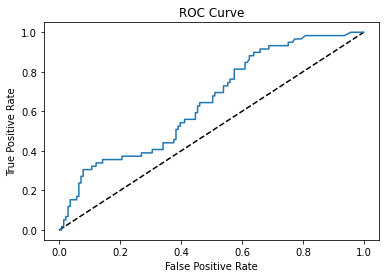

In [118]:
# Prediction proba
y_pred_prob = best_xgb.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

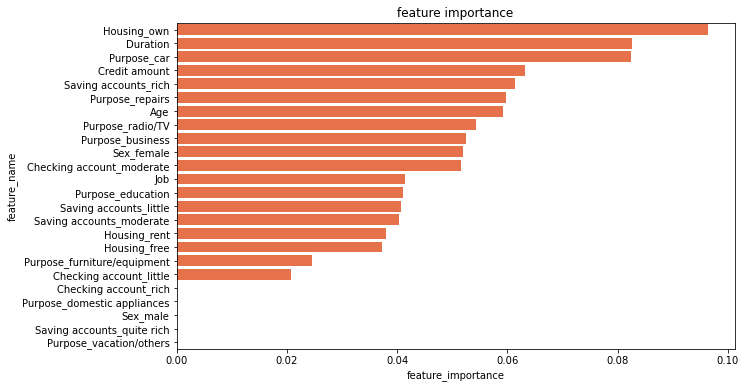

In [119]:
plt.figure(figsize=(10, 6))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance': best_xgb.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()

Overall, XGBoost model has the best performance.